In [1]:
import glob #to read the files
import json #to work if .json
import numpy as np #to math
import pandas as pd #to save the data
import math #to convertion calculus
from astropy.time import Time #to time converting
from astropy import units #time correction
from astropy.coordinates import SkyCoord #time correction
from scipy import interpolate #to interpolate the wavelength and flux
from tabulate import tabulate #to export in table format
from scipy.interpolate import interp1d
#import scipy.optimize as opt
from scipy import optimize
from scipy import signal
import os.path
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy import stats
import os.path 
import sncosmo

In [2]:
kernel = 10.0 * RBF(length_scale=10.0, length_scale_bounds=(5, 15)) + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))

In [3]:
csp = sncosmo.get_magsystem('csp')
ab = sncosmo.get_magsystem('ab')
vega = sncosmo.get_magsystem('vega')

In [4]:
%run ./functions.ipynb

In [5]:
sn_names=glob.glob("*.json")
len(sn_names)

262

In [6]:
maxvalues = []

In [7]:
list_data = []
lightc = []

In [8]:
w = []

In [9]:
for j in range(0,len(sn_names)):  
    
    name = sn_names[j]

    print(name)
    
    with open(name, "r") as read_file:
        data = json.load(read_file)

    url = name
    if url.endswith('.json'):
        url = url[:-5]

    
    redshift = redshift_value(data[url])
    
    if redshift is not None:

        t0 = max_time(data[url])

        mag_v = []
        time_v = []
        system_v = []
        
        mag_g = []
        time_g = []
        system_g = []


        for i in range(0,len(data[url]["photometry"])):

            if "band" in data[url]["photometry"][i]:
                
                w.append(data[url]["photometry"][i]["band"])

                if data[url]["photometry"][i]["band"] == "V":
                    
                    if "system" in data[url]["photometry"][i]:
                        
                        system_v.append(data[url]["photometry"][i]["system"])
                        #w.append(data[url]["photometry"][i]["system"])
                        mag_v.append(float(data[url]["photometry"][i]["magnitude"]))
                        time_v.append(float(data[url]["photometry"][i]["time"]))
                    
                if data[url]["photometry"][i]["band"] == "u":
                    
                    if "system" in data[url]["photometry"][i]:
                        
                        system_g.append(data[url]["photometry"][i]["system"])
                        #w.append(data[url]["photometry"][i]["system"])
                        mag_g.append(float(data[url]["photometry"][i]["magnitude"]))
                        time_g.append(float(data[url]["photometry"][i]["time"]))
            
        #print(system_b)
        if len(time_v) > 4:
            
            #maxvalues.append(min(mag))
            
            ntime = []
            nmag = []
            for i in range(0,len(mag_v)):

                if np.abs(time_v[i]- min(time_v)) < 100:
                    
                    if system_v[i] == "CSP":
                        
                        
                        nmag.append(csp.band_mag_to_flux(mag_v[i], 'cspv9844'))
                        ntime.append([time_v[i]])
                        
                    if system_v[i] == "AB":
                        #print("ab")
                        
                        nmag.append(ab.band_mag_to_flux(mag_v[i], 'cspv9844'))
                        ntime.append([time_v[i]])
                        
                    if system_v[i] == "Vega":
                        
                        #print("vega")
                        nmag.append(vega.band_mag_to_flux(mag_v[i], 'cspv9844'))
                        ntime.append([time_v[i]])   
                        
                    #if system[i] == "w":
                        
                        #print("w")
                        #nmag.append(vega.band_mag_to_flux(mag[i], 'cspv9844'))
                        #ntime.append([time[i]])                     
                                      
                    #print(np.abs(time[i][0] - min(time[i])))                         
                
            if len(nmag) > 4 :   
                
                gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(ntime, nmag)

                X_ = np.linspace(min(ntime)[0], max(ntime)[0], 1000)

                y_mean = gp.predict(X_[:, np.newaxis])

                y_mean = list(y_mean)

                idx = y_mean.index(max(y_mean))

                if idx > 1: 
                    #print("V")
                    maxvalues.append([max(y_mean), -9999, sn_names[j]])

                    lightc.append([X_, y_mean])                    

                #list_data.append(max(y_mean))
                #list_data.append([X_, y_mean])
                
        else:
            #print(system_b)
            #maxvalues.append(min(mag))
            
            ntime = []
            nmag = []
            for i in range(0,len(mag_g)):

                if np.abs(time_g[i]- min(time_g)) < 100:
                    
                    if system_g[i] == "CSP":
                        
                        
                        nmag.append(csp.band_mag_to_flux(mag_g[i], 'sdssu'))
                        ntime.append([time_g[i]])
                        
                    if system_g[i] == "AB":
                        #print("ab")
                        
                        nmag.append(ab.band_mag_to_flux(mag_g[i], 'sdssu'))
                        ntime.append([time_g[i]])
                        
                    if system_g[i] == "Vega":
                        
                        #print("vega")
                        nmag.append(vega.band_mag_to_flux(mag_g[i], 'sdssu'))
                        ntime.append([time_g[i]])   
                        
                    #if system[i] == "w":
                        
                        #print("w")
                        #nmag.append(vega.band_mag_to_flux(mag[i], 'cspv9844'))
                        #ntime.append([time[i]])                     
                                      
                    #print(np.abs(time[i][0] - min(time[i])))                         
                
            if len(nmag) > 4:   
                
                gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(ntime, nmag)

                X_ = np.linspace(min(ntime)[0], max(ntime)[0], 1000)

                y_mean = gp.predict(X_[:, np.newaxis])

                y_mean = list(y_mean)

                idx = y_mean.index(max(y_mean))

                if idx > 1: 
                    
                    maxvalues.append([-9999, max(y_mean), sn_names[j]])

                    lightc.append([X_, y_mean])                    

                #list_data.append(max(y_mean))
                #list_data.append([X_, y_mean])
                

SN2002eu.json
0.037626
SN2006D.json
0.008529
SN2002fb.json
0.015567
SN1999da.json
0.01269
SN1999cw.json
0.01237
SN1999dq.json
0.01433
SN1991T.json
0.005791
SN2006et.json
0.02217798925424974
SN2005eu.json
0.034901
SN1957B.json
0.00659
SN2011ay.json


0.021
LSQ12gpw.json
0.058
SN2001bf.json
0.015501
SN2010ae.json
0.003662
SN2005be.json
0.035001
SN2005kc.json
0.01512
SN2005bl.json
0.02406
SN2005hk.json
0.01306
SN2001ex.json
0.02638
SN2007sr.json
0.005417
SN1999gh.json
0.007679
SN2002cx.json
0.02396
SN2002fk.json
0.007132
SN2004ey.json
0.01579444768273275
SN1998dm.json
0.006541
SN2008C.json
0.01660210068034762
SN2007fs.json
0.01719
SN2001eh.json
0.037039
iPTF13dge.json
0.015854
SN2001br.json
0.020628
SN2009aa.json
0.02731
SN2008ha.json
0.004623
SN2002cs.json
0.01577
SN1995al.json
0.00514
SN2006is.json
0.031330480283491946
SN2006cz.json
0.041799
SN1997bp.json
0.008309
SN2009dc.json
0.02158
SN2002dp.json
0.011639
SN2005al.json
0.012381930324267376
SN2003kf.json
0.007388
SN2000dk.json
0.01744
SN2003W.json
0.020071
SN2008fp.json
0.005656012429203772
SN2006fz.json
0.1047
iPTF14bdn.json
0.01558
SN2004S.json
0.00937
SN2009ad.json
0.02834
SN2006H.json
0.01399
SN1999ee.json
0.01141
SN2007bj.json
0.016708
SN1972E.json
0.001358
SN1999gp.json
0.0

0.01322
SN2008hv.json
0.012526589416171241
SN2001ay.json
0.03024
SN2009ag.json
0.00864
PTF10icb.json
0.008544
SN1995E.json
0.01158
SN2007ca.json
0.014066
SN2007bd.json
0.03096718391784581
SN2012hr.json
0.008
SN2006kf.json
0.02129693315973835
SN2002ha.json
0.014046
SN1998es.json
0.01057
PTF10ops.json
0.06
SN2002bo.json
0.00424
SN2005hj.json
0.05802511117307718
SN2004dt.json
0.01973
SN1994D.json
0.00149
SN1992G.json
0.00529
SN1997br.json
0.006941
SN2001cp.json
0.022402
SN2013E.json
0.009413
SN1997cn.json
0.0162
SN2007jg.json
0.03712646456081914
SN2004ef.json
0.031003287895856158
SN1986G.json
0.00183
SN1956A.json
0.00559
SN2002es.json


0.02843
SN2004at.json
0.023131
SN2017hbi.json
0.04
SN1993Z.json
0.00452
SN2008ae.json
0.03006
SN2004bv.json
0.01061
SN2012cg.json
0.001458
SN2008Q.json
0.007935
SN1992A.json
0.00626
SN2006cj.json
0.067517
SN2007bm.json
0.006211
SN1995bd.json
None
SN2007ax.json
0.006861
SN1981B.json
0.006031
SN2007co.json
0.026962
SN2008J.json
0.015874
SN2005cf.json
0.006461
SN2008ec.json
0.016317
SN2000fa.json
0.02127
SN2010jn.json
0.025047
SN2007ba.json
0.038513
SN2006N.json
0.014277
SN2003fa.json
0.006004
SN2003cg.json
0.00413
SN2004as.json
0.031021
LSQ12gdj.json
0.03
SN1991bg.json
0.003539
SN2009ab.json
0.01117
SN2005ke.json
0.00488
SN2002he.json
0.024564
SN2013cs.json
0.009
SN1995ak.json
0.02272
SN2004bd.json
0.00893
SN2001fe.json
0.013539
SN2016hnk.json
0.016268
SN2004L.json
0.032309
SN1999ac.json
0.0115
SN2012fr.json
0.0054
SN2006bt.json
0.032156
SN2011by.json
redshift nao encontrado
SN2007kk.json
0.041045
SN2006dm.json
0.022019
SN2005eq.json
0.028974294942283096
SN1998de.json
0.01647
SN2002cd.js

In [11]:
system_v

['Vega',
 'Vega',
 'Vega',
 'Vega',
 'Vega',
 'Vega',
 'Vega',
 'Vega',
 'Vega',
 'Vega',
 'Vega',
 'Vega',
 'Vega']

In [11]:

w = np.array(w)
unique, counts = np.unique(w, return_counts=True)
dict_bands = dict(zip(unique, counts))
dict_bands = dict(sorted(dict_bands.items(), key=lambda item: item[1], reverse=True))


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

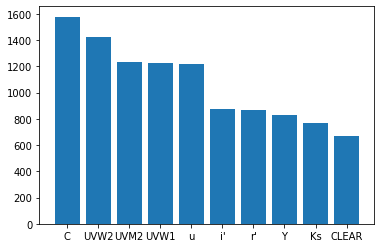

In [12]:
plt.bar(list(dict_bands.keys())[10:20], list(dict_bands.values())[10:20])
plt.plot


In [10]:
save_path = '/home/joao/Documents/'

In [11]:
table = []
for l in range(0,len(maxvalues)):
    table.append((maxvalues[l][2][:-5], maxvalues[l][0],  maxvalues[l][1]))

name_of_file = "max_valuesV"

completeName = os.path.join(save_path, name_of_file+".txt")

f = open(completeName, 'w')
f.write(tabulate(table, tablefmt="plain"))
f.close()

In [13]:
maxvalues[0][1][:-5]

'SN2006D'